<a href="https://colab.research.google.com/github/smartdesignlab/SDL_teaching/blob/main/KAIST_SDL_1_Generative_AI_DDIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Generative AI: Denoising Diffusion Implicit Models (DDIM)**

![DDIM](https://drive.google.com/uc?id=10IVOM5qJYd9N3KTEgd7IPhnS0R9TM_tB)
**Overview**:  

1) Import libraries and set up environment.  
2) Define parameters.  
3) Load and preprocess data.  
4) Initialize model and scheduler.  
5) Run the training loop.  
6) Visualize and analyze results.  


## 1) Import Libraries and Environment Setup

### **| Load dataset & Pre-trained model**


![Dataset](https://drive.google.com/uc?id=1lgZ5KQWqZ_SFswYQktRlDXXFFBoD36d2)


In [1]:
!gdown 1TLpSJW9X9d1l6-3HKbRiLYGqY12RDDju -O dataset.zip
!unzip -q dataset.zip -d ./dataset_56x56_36
!ls ./dataset_56x56_36

# Pre-trained model
!gdown 1pDiVYvrDcdYb5EeVPTCKzmMCpDzrUtui -O Generator_DDIM.pth
!ls -lh Generator_DDIM.pth

Downloading...
From: https://drive.google.com/uc?id=1TLpSJW9X9d1l6-3HKbRiLYGqY12RDDju
To: /content/dataset.zip
100% 41.0k/41.0k [00:00<00:00, 55.8MB/s]
10.png	13.png	16.png	19.png	21.png	24.png	27.png	2.png	32.png	35.png	4.png  7.png
11.png	14.png	17.png	1.png	22.png	25.png	28.png	30.png	33.png	36.png	5.png  8.png
12.png	15.png	18.png	20.png	23.png	26.png	29.png	31.png	34.png	3.png	6.png  9.png
Downloading...
From (original): https://drive.google.com/uc?id=1pDiVYvrDcdYb5EeVPTCKzmMCpDzrUtui
From (redirected): https://drive.google.com/uc?id=1pDiVYvrDcdYb5EeVPTCKzmMCpDzrUtui&confirm=t&uuid=5d5fcfd9-1b56-41c9-b2f8-479ab52cf2df
To: /content/Generator_DDIM.pth
100% 176M/176M [00:05<00:00, 33.8MB/s]
-rw-r--r-- 1 root root 168M Jan 30 05:47 Generator_DDIM.pth


### **| Import python libraries and define util functions**


In [2]:
!pip install --upgrade diffusers[torch]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import random
from diffusers import UNet2DModel, DDIMScheduler
from diffusers.optimization import get_cosine_schedule_with_warmup
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from PIL import Image, ImageDraw, ImageFont

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
from sklearn.model_selection import train_test_split
import torchvision.transforms as T

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", device)

def set_seed(seed=42):
    """Fix random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def img_read(src, file):
    """Read grayscale image as a NumPy array."""
    img = cv.imread(os.path.join(src, file), cv.IMREAD_GRAYSCALE)
    return img


def show_img(images_list,
             r=1,
             cmap='gray',
             img_size=(5, 5),
             axis="off",
             colorbar=False,
             colorbar_range=None,
             save_path=None):
    if r < 1:
        r = 1

    total_images = len(images_list)
    if total_images == 0:
        print("No images to display.")
        return

    cols = (total_images + r - 1) // r
    fig, axs = plt.subplots(r, cols, figsize=(cols * img_size[0], r * img_size[1]))

    if r == 1:
        axs = axs.reshape(1, -1)

    for idx, item in enumerate(images_list):
        ax = axs[0, idx] if r == 1 else axs[idx // cols, idx % cols]
        im = None
        if isinstance(item, Image.Image):
            if item.mode in ['L', '1']:  # Grayscale images
                im = ax.imshow(item, cmap=cmap)
            else:  # Color images
                im = ax.imshow(item)
        elif isinstance(item, np.ndarray):
            if item.ndim == 2:  # 2D array, grayscale image
                im = ax.imshow(item, cmap=cmap, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 3:  # 3D array, color image
                im = ax.imshow(item, cmap=cmap if item.shape[-1] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 4 and item.shape[0] == 1:  # 4D array with batch dimension of 1
                im = ax.imshow(item[0], cmap=cmap if item.shape[1] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            else:
                raise ValueError(f"Unsupported numpy array shape: {item.shape}.")
        elif torch.is_tensor(item):
            item = item.detach().cpu().numpy()
            if item.ndim == 2:  # 2D tensor, grayscale image
                im = ax.imshow(item, cmap=cmap, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 3:  # 3D tensor, color image
                im = ax.imshow(item.transpose(1, 2, 0), cmap=cmap if item.shape[0] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            elif item.ndim == 4 and item.shape[0] == 1:  # 4D tensor with batch dimension of 1
                im = ax.imshow(item[0].transpose(1, 2, 0), cmap=cmap if item.shape[1] == 1 else None, vmin=colorbar_range[0] if colorbar_range else None, vmax=colorbar_range[1] if colorbar_range else None)
            else:
                raise ValueError(f"Unsupported torch tensor shape: {item.shape}.")
        else:
            raise ValueError("Unsupported image type. Supported types: PIL Image, numpy array, torch tensor.")

        if colorbar and im is not None:
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            fig.colorbar(im, cax=cax)

        ax.axis(axis)

    plt.tight_layout()
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def show_img_subplot(images_list, r=6, c=6, cmap='gray', img_size=(2, 2), axis="off", colorbar=False, colorbar_range=None, save_path=None):
    """Display multiple images in a 6x6 grid."""
    total_images = len(images_list)
    fig, axs = plt.subplots(r, c, figsize=(c * img_size[0] * 0.6, r * img_size[1] * 0.6))

    for idx, item in enumerate(images_list[:r * c]):
        ax = axs[idx // c, idx % c]
        if torch.is_tensor(item):
            item = item.detach().cpu().numpy()

        if item.ndim == 2:
            im = ax.imshow(item, cmap=cmap,
                           vmin=colorbar_range[0] if colorbar_range else None,
                           vmax=colorbar_range[1] if colorbar_range else None)
        elif item.ndim == 3:
            if item.shape[0] < 10:
                item = np.transpose(item, (1, 2, 0))
            im = ax.imshow(item, cmap=cmap,
                           vmin=colorbar_range[0] if colorbar_range else None,
                           vmax=colorbar_range[1] if colorbar_range else None)
        else:
            raise ValueError(f"Unsupported shape: {item.shape}")

        ax.axis(axis)

    plt.tight_layout()
    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

def get_data():
    """Load images and normalize."""
    img_files = [f for f in os.listdir(src) if f.endswith('.png')]
    images = []

    for file in img_files[:36]:  # Load only 36 images
        index_str = os.path.splitext(file)[0]
        try:
            _ = int(index_str)
        except ValueError:
            continue
        img = img_read(src, file)
        img_t = T.Compose([
            T.ToPILImage(mode='L'),
            T.ToTensor(),
            T.Normalize(mean=[0.5], std=[0.5])
        ])(img)
        images.append(img_t.numpy())

    images = np.array(images)
    return images



The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Torch version: 2.5.1+cu124
CUDA available: True
Device: cuda:0


## 2) Define Parameters

In [4]:
batch_size = 36
eta = 0.0  # DDIM parameter
seed = 0
set_seed(seed)

NUM_NODES = 57
IMG_H, IMG_W = 56, 56

src = './dataset_56x56_36/'

print("Batch size:", batch_size)
print("Image size:", (IMG_H, IMG_W))
print("Seed:", seed)

Batch size: 36
Image size: (56, 56)
Seed: 0


## 3) Load and Preprocess Data

Train images shape: torch.Size([36, 1, 56, 56])


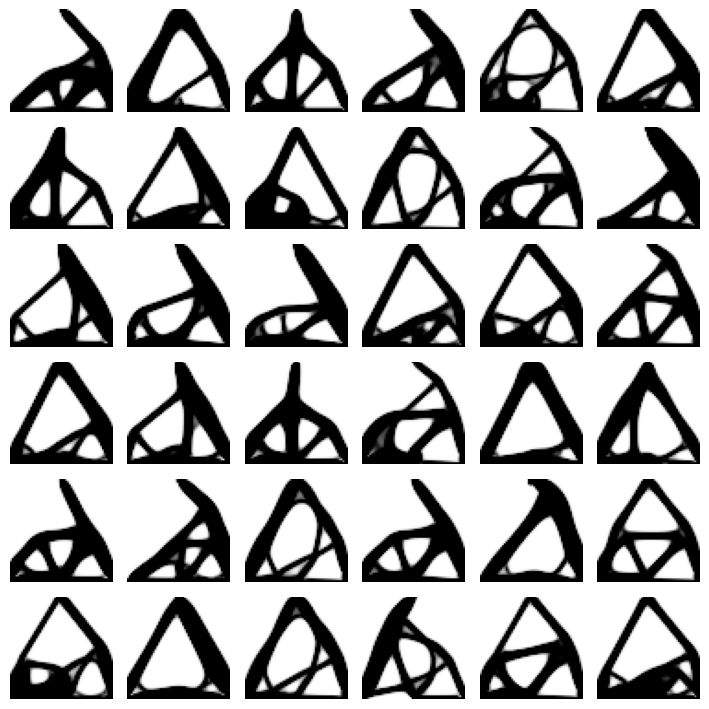

In [5]:
# Load and convert to tensors
train_images = torch.tensor(get_data(), dtype=torch.float32)

print("Train images shape:", train_images.shape)

# Visualize loaded images
show_img_subplot(train_images[:36], r=6, c=6)

## 4) Initialize Model and Scheduler
We create a `UNet2DModel` to predict noise and a `DDIMScheduler` to handle noise scheduling. We also set up our DataLoaders, optimizer, and LR scheduler.

### **| Image Denoising Process**

Use UNet and the DDIM Noise Scheduler to implement a progressive restoration of noisy images. Guide codes are available at [Hugging Face DDIM Pipeline] (https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/ddim/pipeline_ddim.py).

### **| UNet architecture**
![UNet](https://drive.google.com/uc?id=1bSaQgiUU439P38I6w_r60Ia37vslZQLZ)

In [6]:
# UNet model
unet = UNet2DModel(
    sample_size=56,
    in_channels=1,
    out_channels=1,
    layers_per_block=1,
    block_out_channels=[64, 128, 256, 512],
).to(device)


It receives `noisy_images` and `timestep` as inputs and outputs the predicted noise.

torch.Size([4, 1, 56, 56])


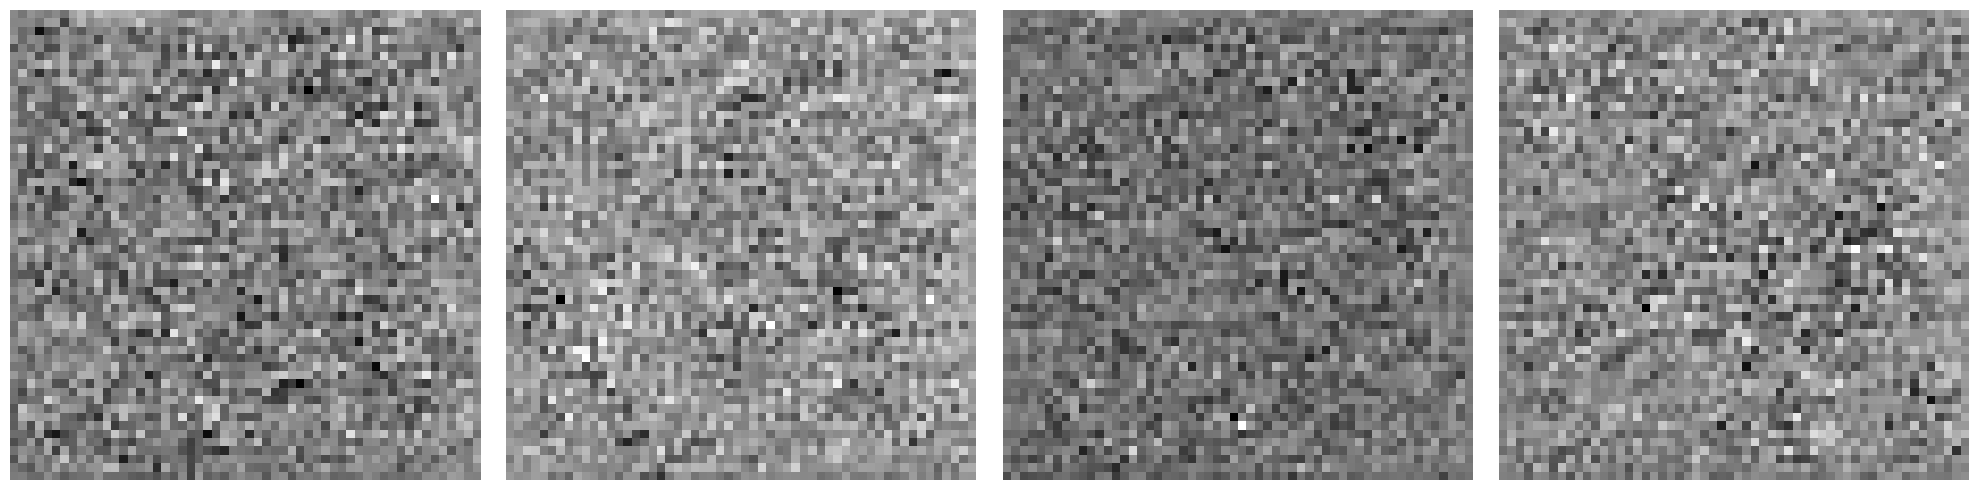

In [7]:
noisy_images = torch.randn((4, 1, 56, 56)).to(device)
timestep = torch.tensor([10]).to(device)
with torch.no_grad():
    pred_noises = unet(noisy_images, timestep).sample
print(pred_noises.shape)
show_img(pred_noises)

### **| Noise scheduler**

In [8]:
noise_scheduler = DDIMScheduler(num_train_timesteps=600)
noise_scheduler.set_timesteps(5) # num_inference_steps = 5
print('timesteps : ', len(noise_scheduler.timesteps), noise_scheduler.timesteps) # check the timesteps

timesteps :  5 tensor([480, 360, 240, 120,   0])


tensor(480)


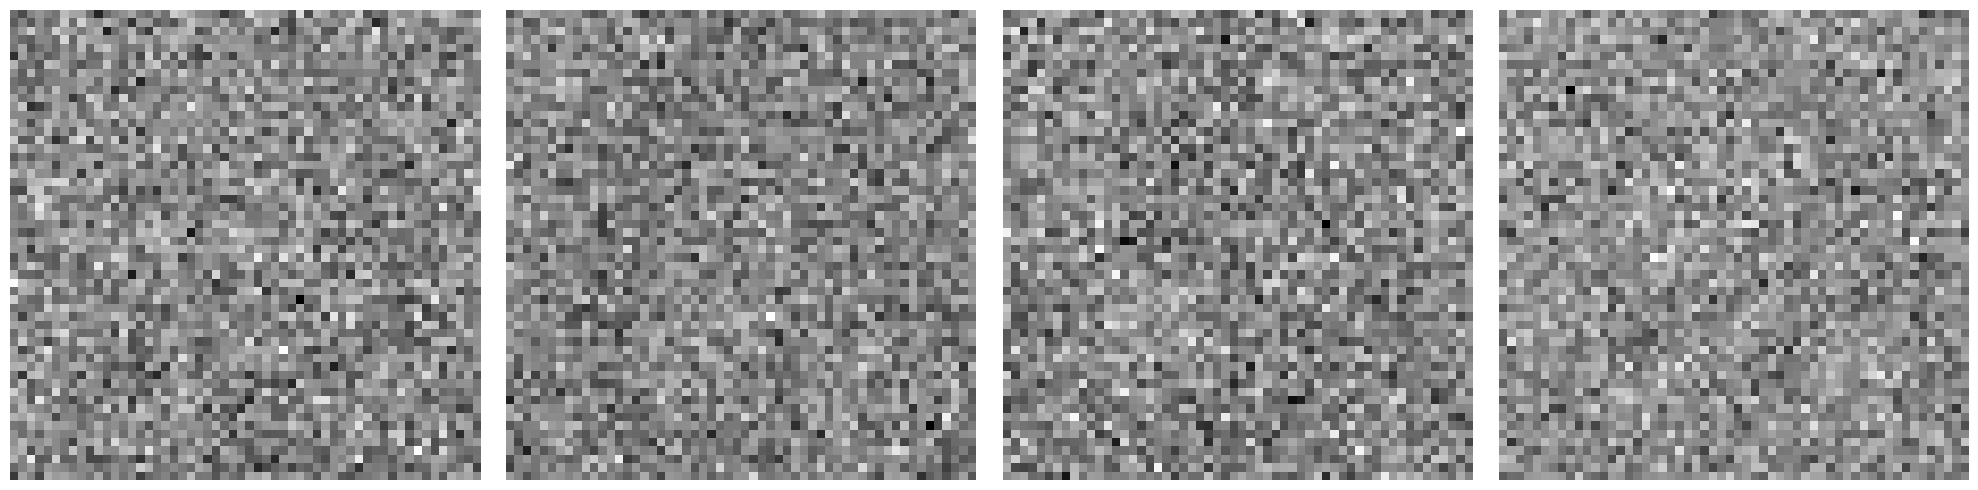

tensor(360)


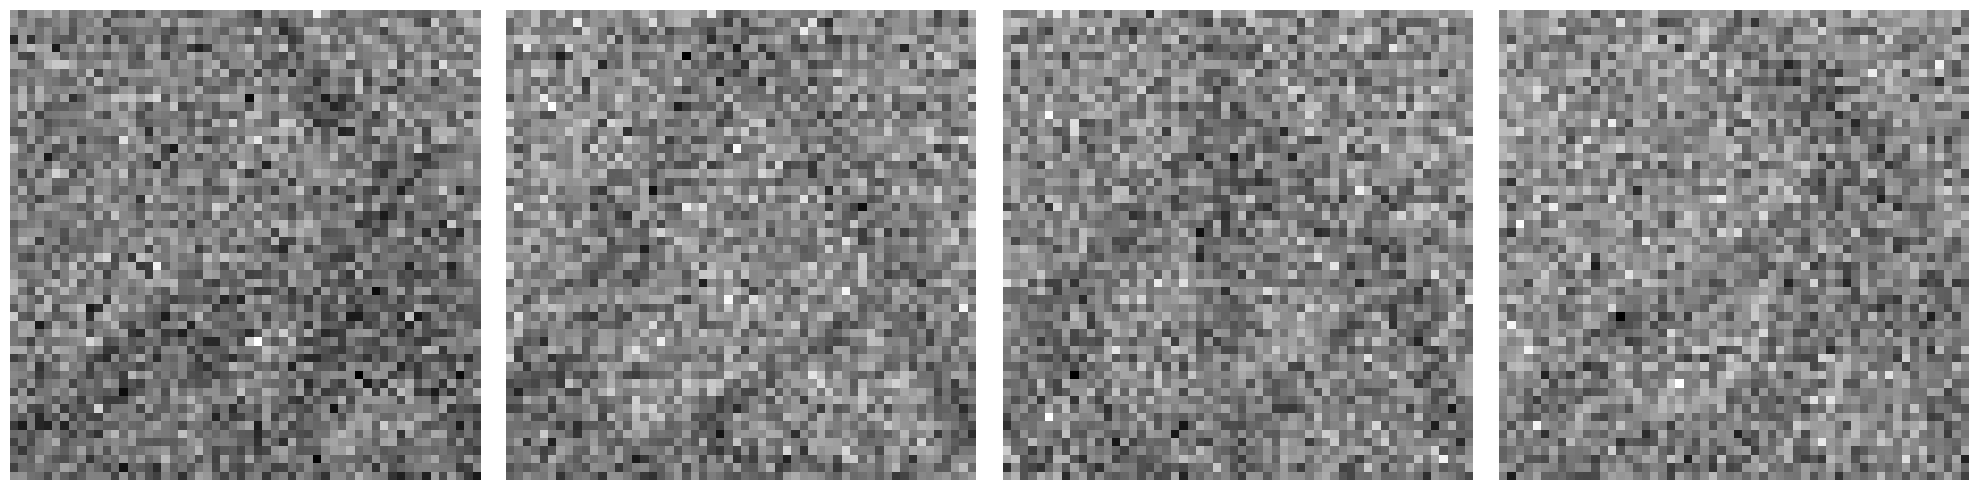

tensor(240)


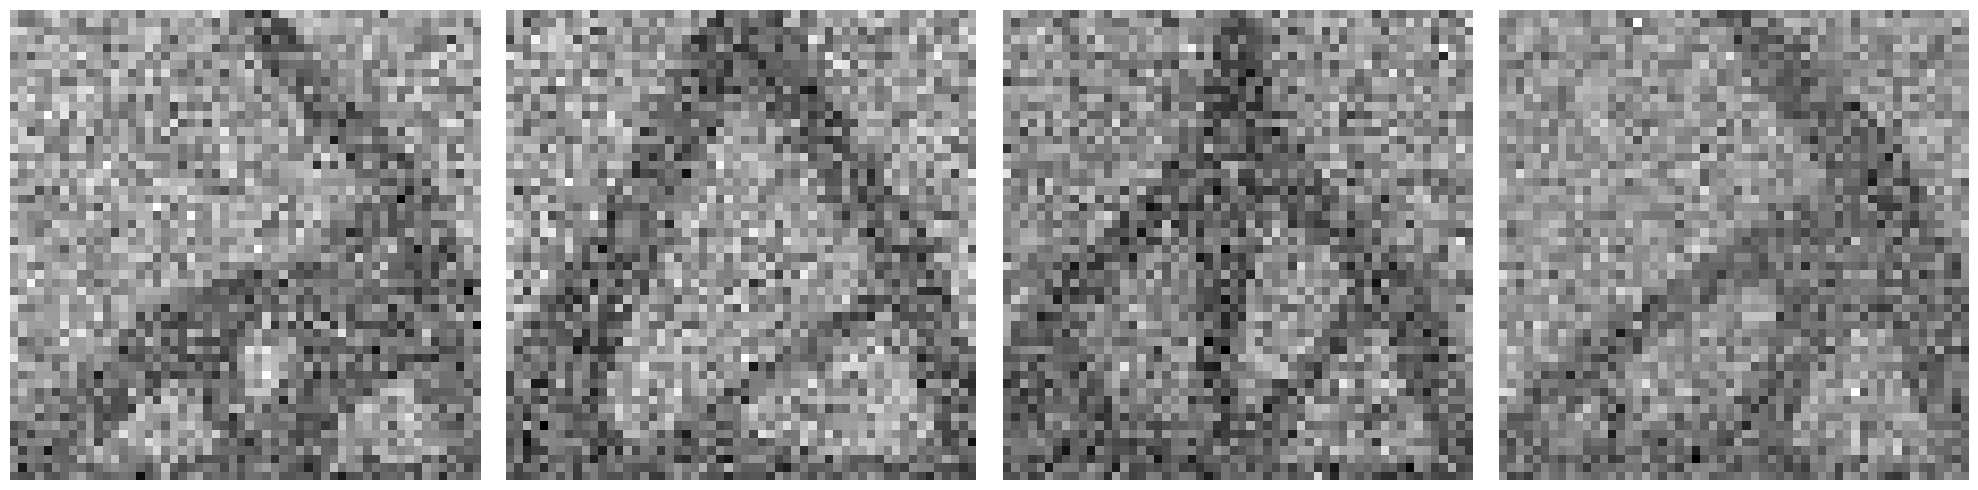

tensor(120)


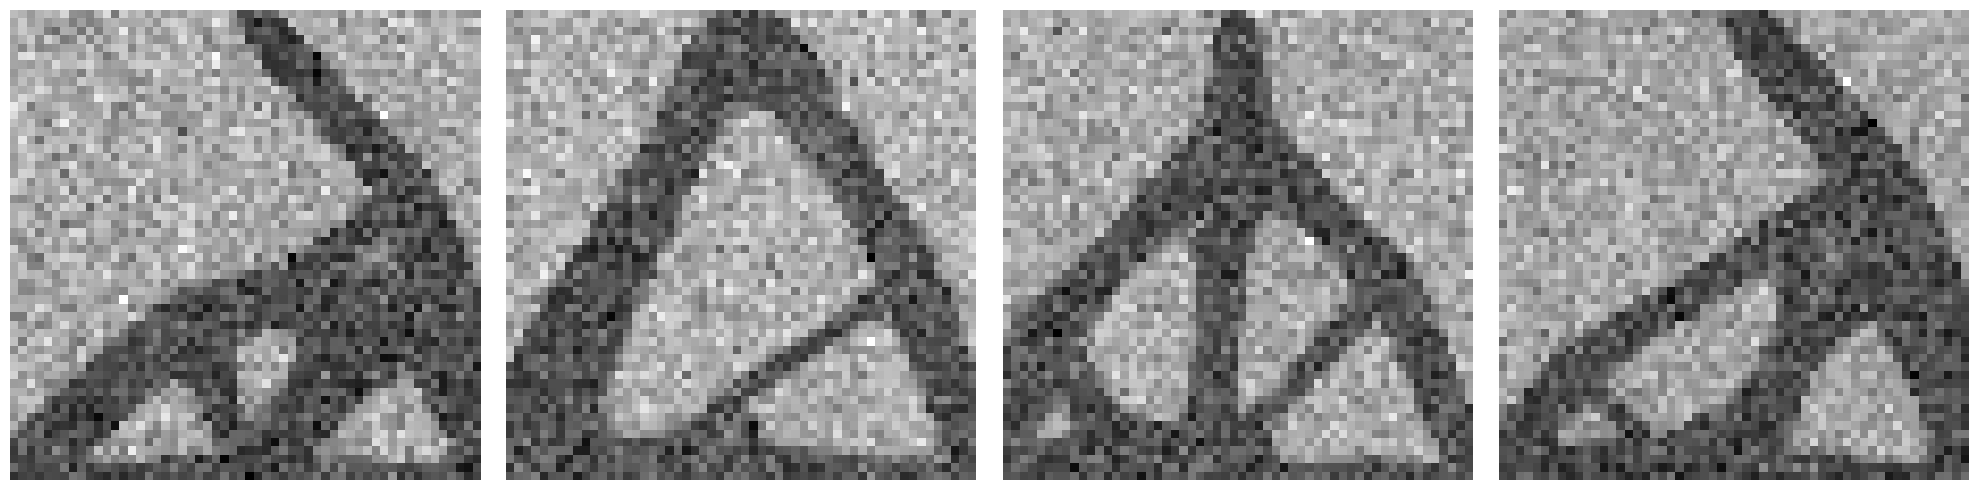

tensor(0)


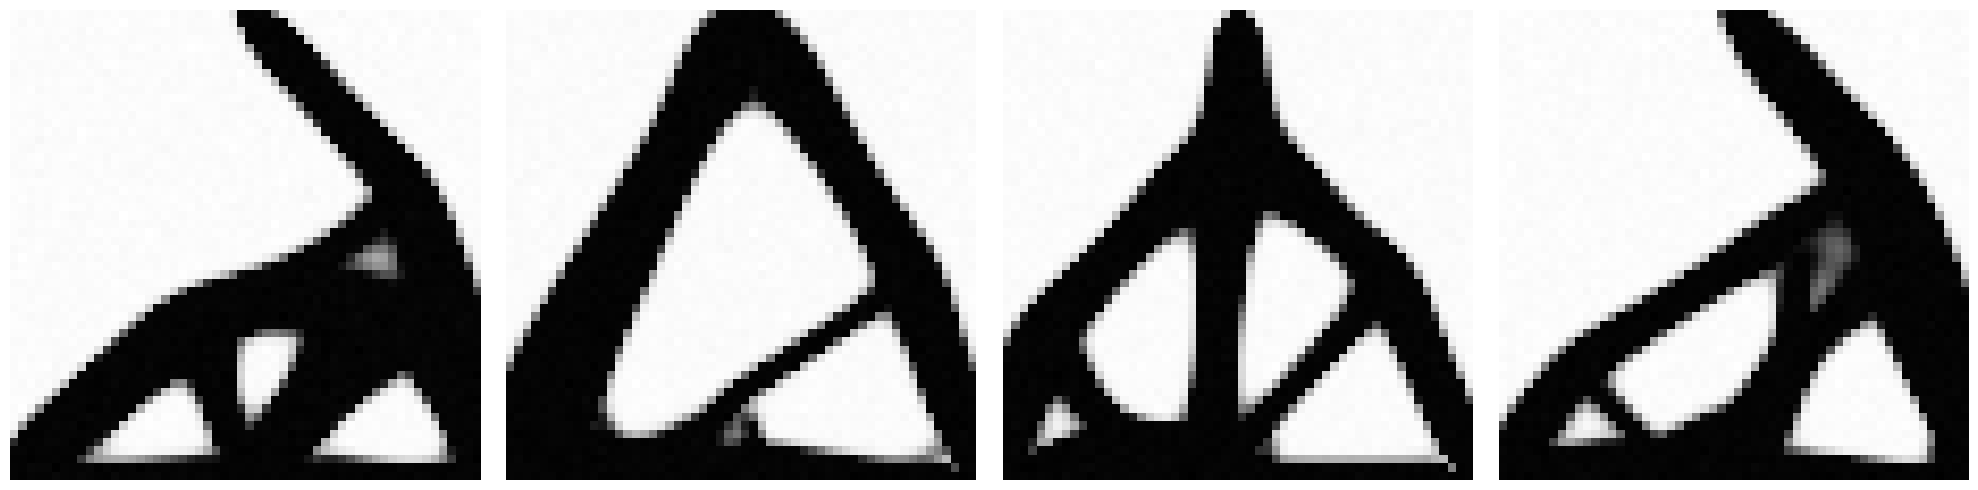

In [9]:
images = train_images[:4].to(device)
for timestep in noise_scheduler.timesteps:
    print(timestep)

    noises = torch.randn(images.shape).to(device)
    noisy_images = noise_scheduler.add_noise(images, noises, timestep)
    show_img(noisy_images)

### **| Image Denoising Process**

Use UNet and the DDIM Noise Scheduler to implement a progressive restoration of noisy images. Guide codes are available at [Hugging Face DDIM Pipeline] (https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/ddim/pipeline_ddim.py).

(4, 1, 56, 56)


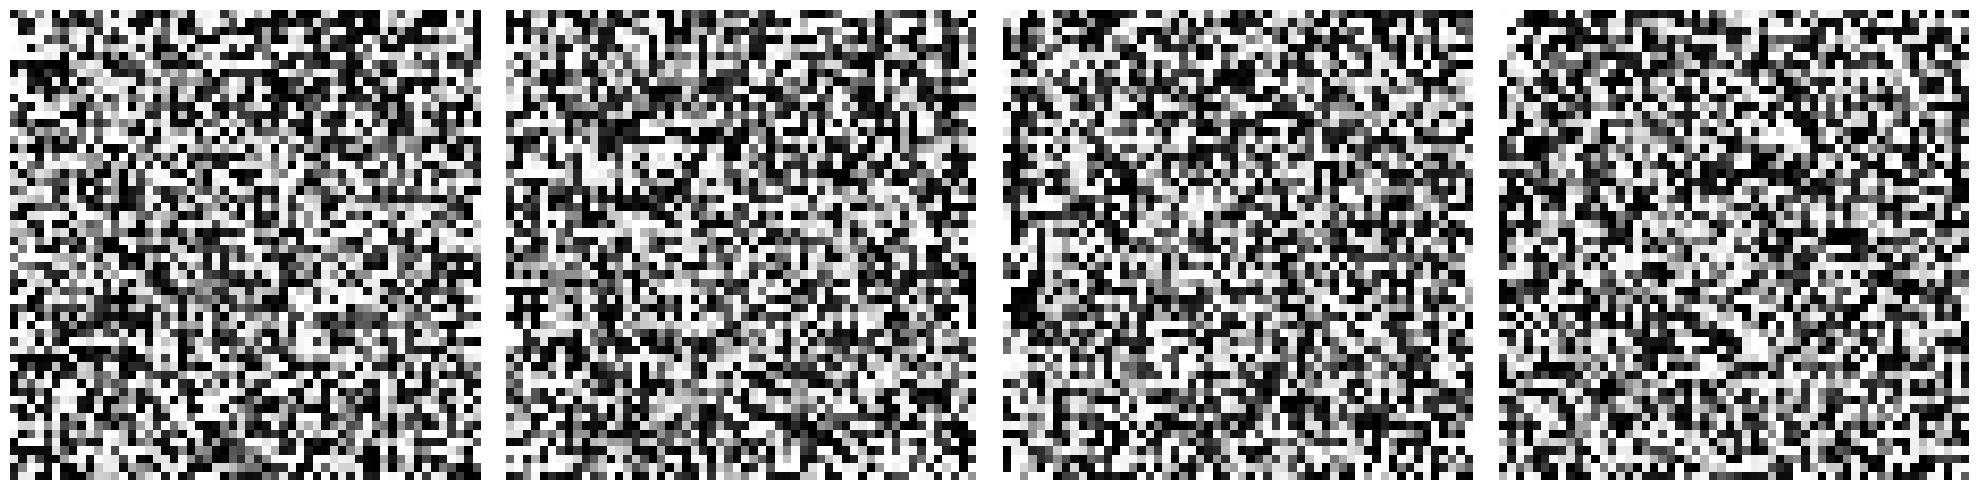

In [ ]:
noise_scheduler.set_timesteps(4) # set up the num of inference steps
images =  torch.randn((4, 1, 56, 56)).to(device) # set up initial noise
for timestep in noise_scheduler.timesteps: # Repeat as many times as timesteps

    with torch.no_grad(): # deactivate gradient calculation
        pred_noises = unet(images, timestep).sample # UNet pipeline
        images  = noise_scheduler.step(pred_noises, timestep, images).prev_sample # denoising step

images = images.cpu().detach().numpy()
print(images.shape)
show_img(images[:,0])

### **| Defining the Diffusion Model**

In [ ]:
# Training hyperparameters
num_train_timesteps = 600
num_inference_steps = 50
num_epochs = 1000
lr_warmup_steps = 100
learning_rate = 1e-4
max_norm = 1  # gradient clipping threshold
n = 10        # number of images to sample during evaluation

# DDIM scheduler
noise_scheduler = DDIMScheduler(num_train_timesteps=num_train_timesteps)

# Create dataset/loader
train_dataset = TensorDataset(train_images)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Optimizer and LR scheduler
optimizer = torch.optim.AdamW(unet.parameters(), lr=learning_rate)
lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=lr_warmup_steps,
    num_training_steps=(len(train_dataset) * num_epochs),
)

output_dir = './'
os.makedirs(output_dir, exist_ok=True)
print("Model, scheduler, optimizer, and DataLoader are set.")


Model, scheduler, optimizer, and DataLoader are set.


## 5) Training Loop
1. Add random noise to images based on a random timestep.
2. Predict the noise using UNet.
3. Compute loss and backprop.
4. Validate with a test set.
5. Save best models.
6. Periodically sample and save generated images.

In [ ]:
start_time = time.time()
best_train_loss = float("inf")
loss_history = {"train_loss": []}

for epoch in range(num_epochs):
    epoch_start = time.time()
    unet.train()
    total_loss = 0.0

    # Training
    for step, imgs in enumerate(train_loader):
        imgs = imgs[0].to(device)
        optimizer.zero_grad()

        # 1) Add noise
        noise = torch.randn_like(imgs)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps,
                                  (imgs.shape[0],), device=device).long()
        noisy_images = noise_scheduler.add_noise(imgs, noise, timesteps)

        # 2) UNet forward
        noise_pred = unet(noisy_images, timesteps).sample

        # 3) Compute loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(unet.parameters(), max_norm)
        optimizer.step()
        lr_scheduler.step()
        total_loss += loss.item()

    average_loss_train = total_loss / len(train_loader)
    loss_history["train_loss"].append(average_loss_train)

    epoch_end = time.time()
    epoch_duration = epoch_end - epoch_start

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {average_loss_train:.6f} | Time: {epoch_duration:.2f}s")


Epoch 1/1000 | Train Loss: 1.092769 | Time: 1.28s
Epoch 2/1000 | Train Loss: 1.087731 | Time: 0.65s
Epoch 3/1000 | Train Loss: 1.082116 | Time: 0.68s
Epoch 4/1000 | Train Loss: 1.075097 | Time: 0.67s
Epoch 5/1000 | Train Loss: 1.053623 | Time: 0.67s
Epoch 6/1000 | Train Loss: 1.041111 | Time: 0.67s
Epoch 7/1000 | Train Loss: 1.015707 | Time: 0.67s
Epoch 8/1000 | Train Loss: 0.995853 | Time: 0.67s
Epoch 9/1000 | Train Loss: 0.975904 | Time: 0.67s
Epoch 10/1000 | Train Loss: 0.958037 | Time: 0.67s
Epoch 11/1000 | Train Loss: 0.923562 | Time: 0.67s
Epoch 12/1000 | Train Loss: 0.903422 | Time: 0.67s
Epoch 13/1000 | Train Loss: 0.871688 | Time: 0.67s
Epoch 14/1000 | Train Loss: 0.845008 | Time: 0.67s
Epoch 15/1000 | Train Loss: 0.807417 | Time: 0.67s
Epoch 16/1000 | Train Loss: 0.783003 | Time: 0.67s
Epoch 17/1000 | Train Loss: 0.767973 | Time: 0.67s
Epoch 18/1000 | Train Loss: 0.714145 | Time: 0.67s
Epoch 19/1000 | Train Loss: 0.702185 | Time: 0.67s
Epoch 20/1000 | Train Loss: 0.666509 | T

## 6) Image generation (inference)

<ipython-input-14-0dc6cc36396b>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  unet.load_state_dict(torch.load("Generator_DDIM.pth", map_location=device))


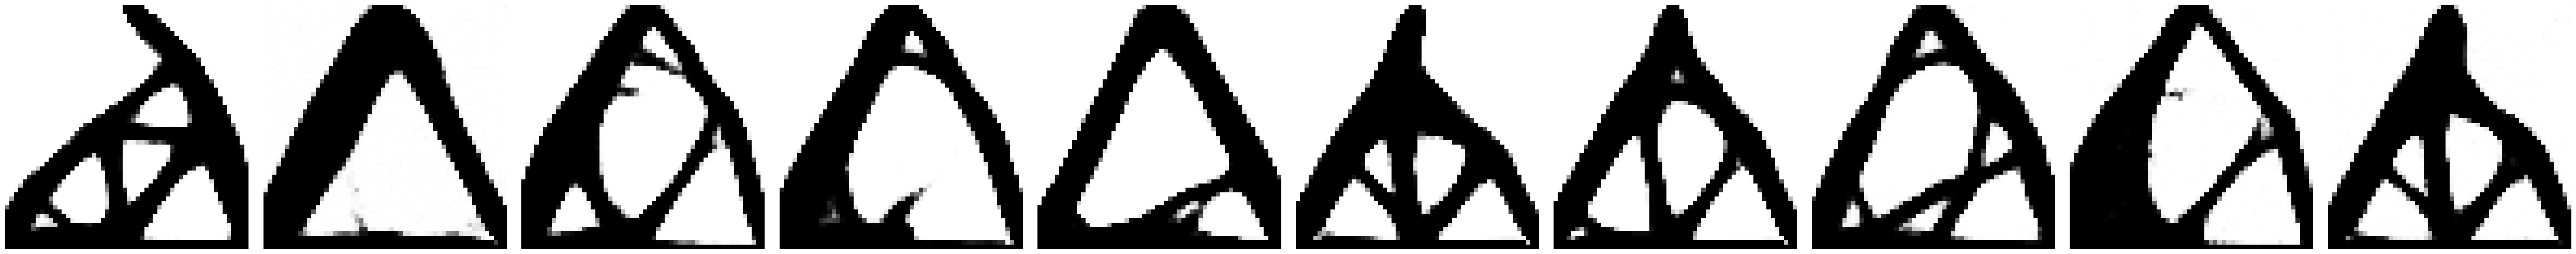

In [ ]:
# Sigmoid filter for post-processing
def sigmoid_filter(img, threshold=0.0, alpha=10.0):
    return torch.sigmoid(alpha * (img - threshold))

unet.load_state_dict(torch.load("Generator_DDIM.pth", map_location=device))
unet.eval()

num_inference_steps = 50
noise_scheduler.set_timesteps(num_inference_steps)

images = torch.randn((10, 1, 56, 56)).to(device)

for timestep in noise_scheduler.timesteps:
    with torch.no_grad():
        pred_noises = unet(images, timestep).sample
    images = noise_scheduler.step(pred_noises, timestep.long(), images).prev_sample

images = sigmoid_filter(images, threshold=0.0, alpha=10.0)
show_img(images.cpu().detach().numpy()[:, 0])

Generating images...
Generating image 10/100...
Generating image 20/100...
Generating image 30/100...
Generating image 40/100...
Generating image 50/100...
Generating image 60/100...
Generating image 70/100...
Generating image 80/100...
Generating image 90/100...
Generating image 100/100...
Image generation completed. 100 images saved to ./DDIM_Generated_images


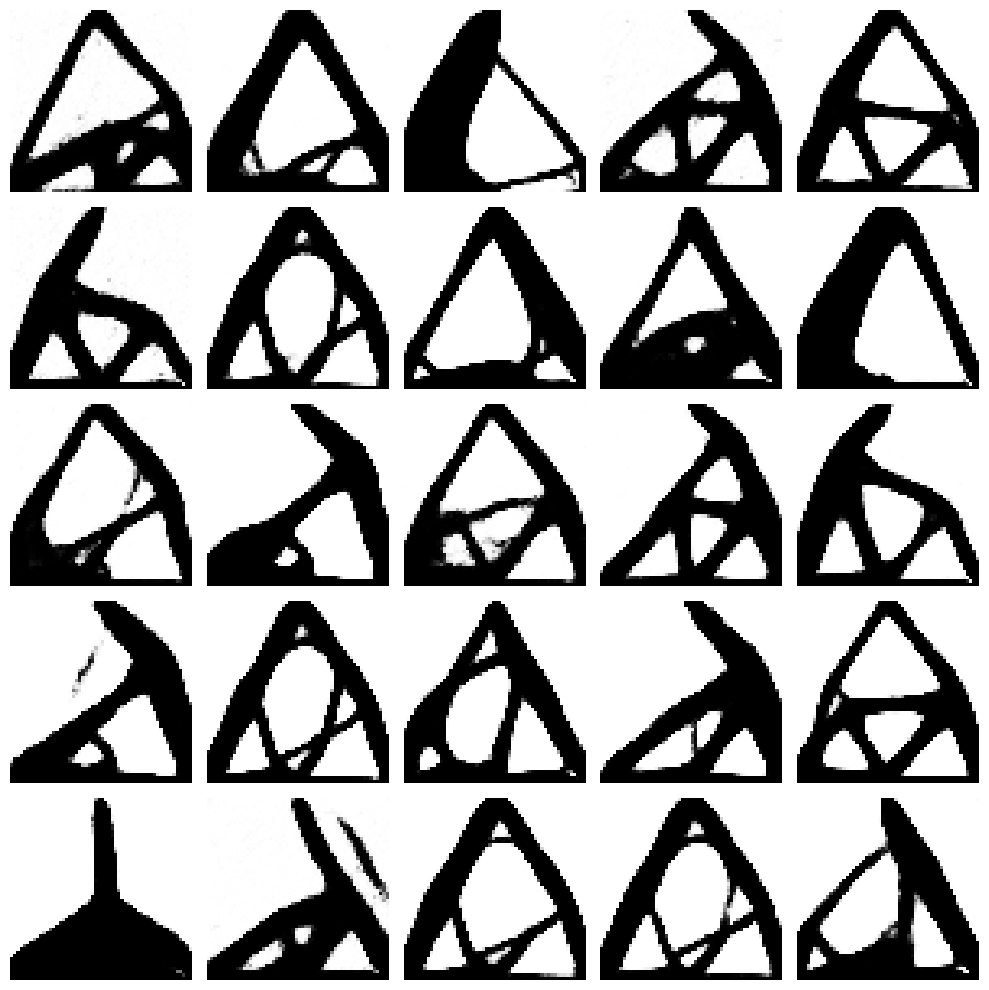

In [ ]:
num_images = 100  # Number of images to generate

# Output directory
output_dir = "./DDIM_Generated_images"
os.makedirs(output_dir, exist_ok=True)

# Initialize DDIM Scheduler
noise_scheduler.set_timesteps(num_inference_steps, eta)

# Set seed for reproducibility
generator = torch.manual_seed(0)

# Generate images
print("Generating images...")
generated_images = []
for i in range(1, num_images + 1):
    if i % 10 == 0:
        print(f"Generating image {i}/{num_images}...")

    # Generate random noise
    images = torch.randn((1, 1, 56, 56), generator=generator).to(device)

    # DDIM Inference (denoising step)
    for timestep in noise_scheduler.timesteps:
        with torch.no_grad():
            pred_noises = unet(images, timestep).sample
        images = noise_scheduler.step(pred_noises, timestep.long(), images).prev_sample

    # Apply sigmoid filter
    images = sigmoid_filter(images, threshold=0.0, alpha=10.0)

    # Save generated image
    image_path = os.path.join(output_dir, f"inference_{i:03d}.png")
    save_image(images, image_path, normalize=True)

    # Store for visualization
    generated_images.append(images.cpu().detach().numpy()[0, 0])

print(f"Image generation completed. {num_images} images saved to {output_dir}")

# Visualize generated images
def show_generated_images(images, rows=5, cols=5):
    fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
    for i, ax in enumerate(axs.flatten()):
        if i >= len(images):
            break
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Display the first 25 generated images
show_generated_images(generated_images, rows=5, cols=5)

## 7) Data labeling
![FEA](https://drive.google.com/uc?id=1aGEcPzFiDNKJJZVfqOltpFffu8POBj3G)

(Andreassen, E., Clausen, A., Schevenels, M., Lazarov, B. S., & Sigmund, O. (2011). Efficient topology optimization in MATLAB using 88 lines of code. Structural and Multidisciplinary Optimization, 43, 1-16.)

In [ ]:
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from PIL import Image
import csv
import os
import re


# 1) Element stiffness matrix (Q4)

def Q4_KE(nu=0.3):
    """Compute element stiffness matrix for Q4 elements."""
    a = np.array([12, 3, -6, 3, 0, -6, -3, -3], dtype=float)
    b = np.array([-4, 3, -2, -9, 4, 2, -3, 9], dtype=float)
    k = (a + nu * b) / (24.0 * (1.0 - nu ** 2))

    i1 = np.array([
        [1, 2, 3, 8],
        [2, 1, 4, 5],
        [3, 4, 1, 7],
        [8, 5, 7, 1]
    ]) - 1
    i2 = np.array([
        [6, 7, 5, 4],
        [7, 6, 8, 3],
        [5, 8, 6, 2],
        [4, 3, 2, 6]
    ]) - 1

    cIndex = np.block([
        [i1, i2],
        [i2, i1]
    ])
    KE = np.zeros((8, 8), dtype=float)
    for rr in range(8):
        for cc in range(8):
            KE[rr, cc] = k[cIndex[rr, cc]]
    return KE


# 2) Generate edofMat for nelx x nely Q4 elements

def generate_edofMat(nelx, nely):
    """
    Each element has 4 nodes (8 DOFs).
    Node indices mapped in row-major order.
    """
    nn = (nelx + 1) * (nely + 1)
    nel = nelx * nely
    edofMat = np.zeros((nel, 8), dtype=int)
    nodeids = np.arange(nn).reshape((nely + 1, nelx + 1))

    idx = 0
    for iy in range(nely):
        for ix in range(nelx):
            n1 = nodeids[iy, ix]
            n2 = nodeids[iy, ix + 1]
            n3 = nodeids[iy + 1, ix + 1]
            n4 = nodeids[iy + 1, ix]
            edofMat[idx, :] = [
                2 * n1, 2 * n1 + 1,
                2 * n2, 2 * n2 + 1,
                2 * n3, 2 * n3 + 1,
                2 * n4, 2 * n4 + 1
            ]
            idx += 1
    return edofMat


# 3) Assign E values from a 56x56 image

def assign_E_from_image(img_path, nelx, nely, threshold=0.5):
    """
    If pixel <= threshold, E=1.0. Otherwise, E=1e-8.
    Flip y-axis so that the bottom of the image corresponds to ey=0.
    """
    pil_img = Image.open(img_path).convert('L')
    arr = np.array(pil_img, dtype=float) / 255.0
    h, w = arr.shape
    if (w != nelx) or (h != nely):
        raise ValueError(f"Image size ({w}x{h}) != ({nelx}x{nely}).")

    Evals = np.zeros(nelx * nely, dtype=float)
    idx = 0
    for ey in range(nely):
        for ex in range(nelx):
            pixel_val = arr[nely - 1 - ey, ex]
            Evals[idx] = 1.0 if pixel_val <= threshold else 1e-8
            idx += 1
    return Evals


# 4) Assemble global stiffness matrix

def assemble_K(edofMat, Evec, KE):
    """
    K matrix built from each element's stiffness KE * E.
    """
    nel = edofMat.shape[0]
    ndof = edofMat.max() + 1

    iK = np.kron(edofMat, np.ones((8, 1))).flatten()
    jK = np.kron(edofMat, np.ones((1, 8))).flatten()

    sK = np.zeros(nel * 64, dtype=float)
    for e in range(nel):
        eFactor = Evec[e]
        sK[e * 64:(e + 1) * 64] = (KE * eFactor).ravel()

    K = coo_matrix((sK, (iK, jK)), shape=(ndof, ndof)).tocsc()
    return K


# 5) Boundary conditions and load vectors

def build_two_load_vectors(nelx, nely):
    """
    - Fixed at bottom-left node (both x,y) and bottom-right node (y).
    - Load1: +x at top-center node.
    - Load2: -y at bottom-center node.
    """
    ndof = 2 * (nelx + 1) * (nely + 1)
    left_bottom_node = 0
    right_bottom_node = nelx
    fixed = [
        2 * left_bottom_node,
        2 * left_bottom_node + 1,
        2 * right_bottom_node + 1
    ]
    fixed = np.array(fixed, dtype=int)

    top_center_node = nely * (nelx + 1) + (nelx // 2)
    bottom_center_node = (nelx // 2)

    F1 = np.zeros(ndof)
    F1[2 * top_center_node] = 1.0

    F2 = np.zeros(ndof)
    F2[2 * bottom_center_node + 1] = -1.0

    all_dofs = np.arange(ndof)
    free_dofs = np.setdiff1d(all_dofs, fixed)
    return free_dofs, F1, F2


# 6) Solve linear system and compute compliance

def solve_compliance(K, free_dofs, F):
    """
    compliance = F^T * U
    """
    ndof = K.shape[0]
    U = np.zeros(ndof, dtype=float)

    K_free = K[free_dofs, :][:, free_dofs]
    F_free = F[free_dofs]
    U_free = spsolve(K_free, F_free)
    U[free_dofs] = U_free
    return F.dot(U), U

# Execute labeling using images from './DDIM_Generated_images'
# Directory containing generated images
image_dir = "./DDIM_Generated_images"

# CSV file for storing compliance labels
csv_file = os.path.join(image_dir, "compliance_label.csv")

# Grid size
nelx, nely = 56, 56

# Precompute element stiffness matrix for Q4
KE = Q4_KE(nu=0.3)

# Build edof matrix
edofMat = generate_edofMat(nelx, nely)

# Create or initialize CSV
if not os.path.exists(csv_file):
    with open(csv_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['index', 'compliance1', 'compliance2'])

# Find all PNG images
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
image_files.sort()

print("Starting labeling process...")
for idx, image_file in enumerate(image_files, 1):
    img_path = os.path.join(image_dir, image_file)

    match = re.search(r'(\d+)', image_file)
    if match:
        image_idx = int(match.group(1))
    else:
        print(f"Skipping file: {image_file} (invalid format)")
        continue

    # Assign E based on image
    Evec = assign_E_from_image(img_path, nelx, nely, threshold=0.5)

    # Assemble global stiffness matrix
    K = assemble_K(edofMat, Evec, KE)

    # Build boundary conditions and load vectors
    free_dofs, F1, F2 = build_two_load_vectors(nelx, nely)

    # Solve compliance for two load cases
    c1, _ = solve_compliance(K, free_dofs, F1)
    c2, _ = solve_compliance(K, free_dofs, F2)

    # Remove abnormal images
    if c1 > 300 or c2 > 300:
        print(f"Removing image {image_file} (compliance1={c1:.2f}, compliance2={c2:.2f})")
        os.remove(img_path)
        continue

    # Append results to CSV
    with open(csv_file, mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([image_idx, c1, c2])

    # Print progress
    if idx % 10 == 0:
        print(f"Labeled {idx}/{len(image_files)} images...")

print(f"Labeling complete. Results saved to: {csv_file}")

Starting labeling process...
Labeled 10/100 images...
Labeled 20/100 images...
Removing image inference_021.png (compliance1=476.48, compliance2=13.08)
Removing image inference_022.png (compliance1=478.32, compliance2=14.97)
Removing image inference_029.png (compliance1=7586.73, compliance2=1789.59)
Labeled 30/100 images...
Removing image inference_034.png (compliance1=772.37, compliance2=20.03)
Removing image inference_035.png (compliance1=883.64, compliance2=13.93)
Labeled 40/100 images...
Removing image inference_047.png (compliance1=8261.75, compliance2=1927.50)
Labeled 50/100 images...
Removing image inference_052.png (compliance1=190720875.53, compliance2=47680273.92)
Removing image inference_057.png (compliance1=387.28, compliance2=13.12)
Labeled 60/100 images...
Removing image inference_064.png (compliance1=54358665.51, compliance2=13589654.12)
Labeled 70/100 images...
Labeled 80/100 images...
Removing image inference_081.png (compliance1=768.73, compliance2=15.17)
Removing ima